# Deuteron electrodisintegration

_Last update:_ January 7, 2025

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.linalg import det, norm, solve
from scipy.interpolate import InterpolatedUnivariateSpline, RectBivariateSpline
from scipy.special import lpmv, sph_harm
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_channel, label_ticks
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_vector
)
from scripts.potentials import Potential
from scripts.tools import (
    build_coupled_channel_matrix, coupled_channel,
    decompose_coupled_channel_matrix
)
from scripts.wave_function import wave_function

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Classes

In [4]:
class PartialWaveChannel:
    """
    Partial wave channel class. Packs together the quantum numbers of a partial
    wave channel into one object.
    
    Parameters
    ----------
    channel : str
        Name of the channel (e.g., '1S0').
    
    """

    
    def __init__(self, channel):
    
        # Set instance attributes
        self.channel = channel
        self.L, self.Lp = self.get_orbital_angular_momentum()
        self.J = self.get_angular_momentum()
        self.S = self.get_spin()
        self.T = self.get_isospin(self.L, self.S)

        
    def __eq__(self, channel):

        if (
            self.L == channel.L and self.Lp == channel.Lp
            and self.J == channel.J and self.S == channel.S
            and self.T == channel.T
        ):
            
            return True
        
        else:
            
            return False
    
    
    def get_orbital_angular_momentum(self):
        """Gets the total orbital angular momentum L and L'."""
        
        if self.channel[1] == 'S':
            L = 0
        elif self.channel[1] == 'P':
            L = 1
        elif self.channel[1] == 'D':
            L = 2
        elif self.channel[1] == 'F':
            L = 3
        elif self.channel[1] == 'G':
            L = 4
        elif self.channel[1] == 'H':
            L = 5
        else:
            raise RuntimeError("Channel L exceeds the range of the function.")
            
        # Coupled-channel
        if coupled_channel(self.channel[:3]):
            
            if self.channel[5] == 'S':
                Lp = 0
            elif self.channel[5] == 'P':
                Lp = 1
            elif self.channel[5] == 'D':
                Lp = 2
            elif self.channel[5] == 'F':
                Lp = 3
            elif self.channel[5] == 'G':
                Lp = 4
            elif self.channel[5] == 'H':
                Lp = 5
            else:
                raise RuntimeError(
                    "Channel L' exceeds the range of the function.")
        
        # L = L' if the channel is not coupled
        else:
            
            Lp = L
            
        return L, Lp
    
    
    def get_angular_momentum(self):
        """Total angular momentum J = 0, 1, 2, ..."""
        
        J = int(self.channel[2])
        
        return J
    
    
    def get_spin(self):
        """Total spin S = 0 or 1."""
        
        S = int((int(self.channel[0])-1)/2)
        
        return S
    
    
    def get_isospin(self, L, S):
        """Total isospin according to antisymmetry."""
    
        # Make sure [1-(-1)^(L+S+T)] is not zero
        if (1 - (-1) ** (L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T

In [5]:
class TMatrix(Potential):
    
    def __init__(self, kvnn, channel_full, kmax, kmid, ntot):
        
        # Set channel argument to be compatible with potential functions
        channel_short = coupled_channel_shorthand(channel_full)
        
        # Initialize Potential class
        super().__init__(kvnn, channel_short, kmax, kmid, ntot)
        
        # Get potential in units fm
        V_matrix = self.load_potential()
        
        # Load momenta and weights in fm^-1
        self.k_array, self.k_weights = self.load_mesh()
        
        # Maximum momentum value in fm^-1
        self.k_max = round(max(self.k_array))
        
        # Number of points in momentum mesh
        self.ntot = ntot
        
        # Interpolate potential
        if self.coupled_channel_bool:
            
            # Get V sub-blocks
            V11, V12, V21, V22 = decompose_coupled_channel_matrix(V_matrix)
        
            # Interpolate each sub-block separately
            self.V11_func = RectBivariateSpline(self.k_array, self.k_array, V11)
            self.V12_func = RectBivariateSpline(self.k_array, self.k_array, V12)
            self.V21_func = RectBivariateSpline(self.k_array, self.k_array, V21)
            self.V22_func = RectBivariateSpline(self.k_array, self.k_array, V22)
            
        else:
            
            self.V_func = RectBivariateSpline(self.k_array, self.k_array,
                                              V_matrix)

#         # Interpolate T-matrix (potentially sub-block if coupled channel)
#         if channel_full in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            
#             self.interpolate(q_array, T_matrix[:self.ntot,self.ntot:])
                
#         elif channel_full in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            
#             self.interpolate(q_array, T_matrix[self.ntot:,:self.ntot])
                
#         elif channel_full in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            
#             self.interpolate(q_array, T_matrix[self.ntot:,self.ntot:])
        
#         # This works on single channel as well
#         else:
            
#             self.interpolate(q_array, T_matrix[:self.ntot,:self.ntot])
        
    def evaluate(self, k0):
        """Evaluate the T-matrix with scattering energy E = (\hbar*k0)^2 / M."""

        # Build D_vector
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0/np.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - k0 ** 2))
        # ntot+1 element of D_vector [fm^-1]
        D_last = (
            -2.0/np.pi * k0 ** 2
            * (np.sum(self.k_weights / (self.k_array ** 2 - k0 ** 2))
               + np.log((self.k_max + k0) / (self.k_max - k0)) / (2.0 * k0))
        ) - 1j * k0
        # Append ntot+1 element to D_vector
        D_vector = np.append(D_vector, D_last) # Length is now ntot+1
        
        # k0 can be appended to end of k_array regardless of its value
        k_full = np.append(self.k_array, k0)
        
        # Create meshes for interpolation
        k_grid, kp_grid = np.meshgrid(k_full, k_full, indexing='ij')
        
        if self.coupled_channel_bool:
            
            # Append k0 points by using the interpolated potential
            V11_matrix = self.V11_func.ev(k_grid, kp_grid)
            V12_matrix = self.V12_func.ev(k_grid, kp_grid)
            V21_matrix = self.V21_func.ev(k_grid, kp_grid)
            V22_matrix = self.V22_func.ev(k_grid, kp_grid)
            
            # Build coupled-channel matrix
            V_matrix = build_coupled_channel_matrix(V11_matrix, V12_matrix,
                                                    V21_matrix, V22_matrix)

            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(2 * (self.ntot + 1))
                + np.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_matrix
            )
            
        else:
            
            # Append k0 points by using the interpolated potential
            V_matrix = self.V_func.ev(k_grid, kp_grid)
            
            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(self.ntot + 1)
                + np.tile(D_vector, (self.ntot + 1, 1)) * V_matrix
            )
            
        # Calculate T-matrix in fm
        T_matrix = solve(F_matrix, V_matrix)
        
        return T_matrix
    
    ### TESTING R-MATRIX
    def test_phase_shifts(self, k0):
        """Get phase shifts from R-matrix."""
        
        # Build D_vector
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0/np.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - k0 ** 2))
        # ntot+1 element of D_vector [fm^-1]
        D_last = (
            -2.0/np.pi * k0 ** 2
            * (np.sum(self.k_weights / (self.k_array ** 2 - k0 ** 2))
               + np.log((self.k_max + k0) / (self.k_max - k0)) / (2.0 * k0))
        )
        # Append ntot+1 element to D_vector
        D_vector = np.append(D_vector, D_last) # Length is now ntot+1
        
        # k0 can be appended to end of k_array regardless of its value
        k_full = np.append(self.k_array, k0)
        
        # Create meshes for interpolation
        k_grid, kp_grid = np.meshgrid(k_full, k_full, indexing='ij')
        
        if self.coupled_channel_bool:
            
            # Append k0 points by using the interpolated potential
            V11_matrix = self.V11_func.ev(k_grid, kp_grid)
            V12_matrix = self.V12_func.ev(k_grid, kp_grid)
            V21_matrix = self.V21_func.ev(k_grid, kp_grid)
            V22_matrix = self.V22_func.ev(k_grid, kp_grid)
            
            # Build coupled-channel matrix
            V_matrix = build_coupled_channel_matrix(V11_matrix, V12_matrix,
                                                    V21_matrix, V22_matrix)

            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(2 * (self.ntot + 1))
                + np.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_matrix
            )
            
        else:
            
            # Append k0 points by using the interpolated potential
            V_matrix = self.V_func.ev(k_grid, kp_grid)
            
            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(self.ntot + 1)
                + np.tile(D_vector, (self.ntot + 1, 1)) * V_matrix
            )
            
        # Calculate T-matrix in fm
        R_matrix = solve(F_matrix, V_matrix)
        
        return R_matrix

In [6]:
class DeuteronElectrodisintegration:
    """Class that calculates the longitudinal structure function for deuteron
    electrodisintegration.
    """
    
    def __init__(
            self, channels, kvnn=6, kmax=30.0, kmid=4.0, ntot=120,
            form_factor_test=False
    ):
        
        # Make sure all constants are in units fm^-1
        self.hbar_c = 197.32696  # \hbar c [MeV fm]
        M_n = 939.56563 / self.hbar_c  # Neutron mass [fm^-1]
        M_p = 938.27231 / self.hbar_c  # Proton mass [fm^-1]
        self.M = (M_p + M_n) / 2  # Nucleon mass [fm^-1]
        self.B_d = 2.224 / self.hbar_c  # Binding energy of deuteron [fm^-1]
        self.M_d = 2 * self.M - self.B_d  # Deuteron mass [fm^-1]
        self.alpha = 1 / 137.03599  # Fine structure constant
        
        # Set table of Clebsch-Gordan coefficients with j_max = 2
        self.cg_table = compute_clebsch_gordan_table(2)
        
        # Interpolate deuteron wave function and set as instance attribute
        self.set_deuteron_wf(kvnn, kmax, kmid, ntot)
        
        # Set potential as instance attribute
        self.kvnn, self.kmax, self.kmid, self.ntot = kvnn, kmax, kmid, ntot
        
#         ### TESTING GEp(Q2=0)
#         print(f'Form factors at Q2=0: {GEp(0.0)}, {GEn(0.0)}')
        
        # Option to set form factors to 1 (GEp) and 0 (GEn)
        self.form_factor_test = form_factor_test
        
        ### TESTING SUSHANT'S FORM FACTORS
        self.ff = FormFactors()
        
        # Set cos(\theta) integration mesh
        self.theta_array, self.theta_weights = gaussian_quadrature_mesh(np.pi,
                                                                        15)
        
        # Pre-compute nested sums in FSI term
        self.fsi_quantum_numbers = self.fsi_sum(channels)

    def set_deuteron_wf(self, kvnn, kmax, kmid, ntot):
        """Set deuteron S- and D-wave functions as instance attributes."""

        # Set-up potential in 3S1-3D1 coupled channel
        potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
        
        # Hamiltonian in MeV
        H_matrix = potential.load_hamiltonian()
        
        # Momentum mesh in fm^-1
        self.k_array, self.k_weights = potential.load_mesh()
        
        # Load deuteron wave function [unitless]
        psi_d_unitless = wave_function(H_matrix)
        # Convert to units fm^3/2
        psi_d_units = unattach_weights_from_vector(
            self.k_array, self.k_weights, psi_d_unitless, coupled_channel=True)
        # Split into S- and D-waves
        psi_0_array = psi_d_units[:ntot]  # S-wave [fm^3/2]
        psi_2_array = psi_d_units[ntot:]  # D-wave [fm^3/2]
        
        # Interpolate and set functions as instance attributes
        self.psi_0_func = InterpolatedUnivariateSpline(self.k_array,
                                                       psi_0_array)
        self.psi_2_func = InterpolatedUnivariateSpline(self.k_array,
                                                       psi_2_array)
        
        ### TESTING NORMALIZATION OF \PSI
        self.norm = 2/np.pi * np.sum(
            self.k_weights * self.k_array ** 2
            * (psi_0_array ** 2 + psi_2_array ** 2)
        )

    def omega(self, Ep_ifm, q):
        """Energy of virtual photon \omega in CoM frame [fm^-1]."""

        return Ep_ifm + 2 * self.M - np.sqrt(self.M_d ** 2 + q ** 2)

    def Q2(self, omega, q):
        """Four-momentum transfer squared Q^2 = -q^2 [GeV^2]."""
        
        # Q^2 in fm^-2
        Q2 = q ** 2 - omega ** 2
        
        # Convert Q^2 to GeV^2
        return Q2 * (self.hbar_c / 1000) ** 2  
    
    def p_prime(self, Ep_ifm):
        """Magnitude of proton momentum p' in CM frame [fm^-1]."""
        
        return np.sqrt(self.M * Ep_ifm + Ep_ifm ** 2 / 4)
    
    def E_prime(self, pp):
        """E' from p' [MeV]."""
        
        Ep_ifm = 2 * np.sqrt(self.M ** 2 + pp ** 2) - 2 * self.M
        
        # Return in units MeV
        return Ep_ifm * self.hbar_c
    
    def nucleon_energy(self, pp):
        """Energy of the proton (neutron) [fm^-1] using E'^2 = p'^2 + M^2."""

        return np.sqrt(self.M ** 2 + pp ** 2)
    
    def deuteron_energy(self, q):
        """Energy of the deuteron [fm^-1] using E_d^2 = q^2 + M_d^2."""

        return np.sqrt(self.M_d ** 2 + q ** 2)

    def longitudinal_sf(self, Ep, thetap, q, fsi=False):
        """Longitudinal structure function f_L [fm] where the arguments are E'
        [MeV], \theta' [deg], and q [fm^-1].
        """
        
        # Start at zero and sum S_f, m_S_f, and m_J_d
        f_L = 0.0
        
        # Convert E' to fm^-1
        Ep_ifm = Ep / self.hbar_c
        
        # Convert \theta' to radians
        thetap_radians = np.radians(thetap)

#         pp = np.sqrt((self.omega(Ep_ifm, q) - self.B_d) * self.M
#                      + q ** 2 * self.M / (2 * self.M_d))  # fm^-1
        # Kinematic variables p' [fm^-1], E_N [fm^-1], and E_d [fm^-1]
        pp = self.p_prime(Ep_ifm)
        self.E_N = self.nucleon_energy(pp)
        self.E_d = self.deuteron_energy(q)

        # Kinematic factor has units fm^-1
        kinematic_factor = -np.pi * np.sqrt(2 * self.alpha * pp * self.E_N
                                            * self.E_d / self.M_d)

        # Sum over S_f, m_S_f, and m_J_d
        S_f_array = np.array([0, 1])
        m_J_d_array = np.array([-1, 0, 1])
        for S_f in S_f_array:
            m_S_f_array = np.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                for m_J_d in m_J_d_array:
                    
                    # Equation 2
                    # Overlap has units fm^3/2
                    overlap_ia = self.overlap_ia(Ep_ifm, pp, thetap_radians, q,
                                                 S_f, m_S_f, m_J_d)
                    if fsi:
                        overlap = overlap_ia + self.overlap_fsi(
                            Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d
                        )
                    else:
                        overlap = overlap_ia

                    # Amplitude of the longitudinal structure function
                    T = kinematic_factor * overlap  # fm^1/2
                    
                    # Add magnitude of amplitude squared to structure function
                    f_L += np.abs(T) ** 2
                    
        return f_L

    def overlap_ia(
            self, Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d, test=False
    ):
        """Overlap matrix element [fm^3/2] in the impulse approximation."""
        
        # Start at zero and sum over L_d
        overlap = 0 + 0j
        
        # Deuteron orbital angular momentum projection m_L_d = m_J_d - m_S_f
        m_L_d = m_J_d - m_S_f
        
        # Call electric form factors
        if self.form_factor_test:
            gep = 1.0
            gen = 0.0
        else:
            omega = self.omega(Ep_ifm, q)  # fm^-1
            Q2 = self.Q2(omega, q)  # GeV^2
#             gep = GEp(Q2)
#             gen = GEn(Q2)

            ### TESTING SUSHANT'S FORM FACTORS
            gep = self.ff.GEp(Q2)
            gen = self.ff.GEn(Q2)
        
        # Dot product p'_vector \dot q_vector
        pqx = pp * q * np.cos(thetap_radians)
        
        # Magnitude of momenta |p'_vector +/- q_vector / 2|
        pq_minus = np.sqrt(pp ** 2 + q ** 2 / 4 - pqx)
        pq_plus = np.sqrt(pp ** 2 + q ** 2 / 4 + pqx)
        
        # Angles between the unit vector z^\hat and p'_vector -/+ q_vector / 2
        theta_minus = np.arccos((pp * np.cos(thetap_radians) - q / 2)
                                / pq_minus)
        theta_plus = np.arccos((pp * np.cos(thetap_radians) + q / 2)
                               / pq_plus)
        
        ### TESTING: Check \Omega_(p +/- q/2) at extremes of \theta'
        if test:
            print(f"\Omega_(p +/- q/2) at theta' = {thetap_radians:.3f}:")
            print(f"theta_minus = {theta_minus:.3f}, "
                  f"theta_plus = {theta_plus:.3f}")
        
        # No dependence on \phi' -> Set to zero!
        phip = np.zeros_like(theta_minus)
        
        # Sum over deuteron orbital angular momentum L_d
        L_d_array = np.array([0, 2])
        for L_d in L_d_array:
            
            # Make sure |m_L_d| <= L_d
            if np.abs(m_L_d) <= L_d:
            
                # Clebsch-Gordan coefficient
                cg = self.cg_table[(L_d, m_L_d, 1, m_S_f, 1, m_J_d)]
                
                # Spherical harmonics
                Ylm_minus = sph_harm(m_L_d, L_d, phip, theta_minus)
                Ylm_plus = sph_harm(m_L_d, L_d, phip, theta_plus)
                
                # Deuteron wave function in fm^3/2
                if L_d == 0:
                    psi_minus = self.psi_0_func(pq_minus)
                    psi_plus = self.psi_0_func(pq_plus)
                elif L_d == 2:
                    psi_minus = self.psi_2_func(pq_minus)
                    psi_plus = self.psi_2_func(pq_plus)

                overlap += np.sqrt(2 / np.pi) * cg * (
                    gep * psi_minus * Ylm_minus + gen * psi_plus * Ylm_plus
                )
                
        return overlap
    
    def fsi_sum(self, channels):
        """Store all non-zero combinations of quantum numbers for nested sums
        in the FSI term.
        """
        
        # Store combinations of quantum numbers in dictionary with S_f, m_S_f,
        # and m_J_d serving as the key
        fsi_quantum_numbers = {}
        
        S_f_array = np.array([0, 1])
        m_J_d_array = np.array([-1, 0, 1])
        m_s_array = np.array([-1, 0, 1])
        L_d_array = np.array([0, 2])
        
        # Sum over S_f, m_S_f, and m_J_d
        for S_f in S_f_array:
            m_S_f_array = np.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                for m_J_d in m_J_d_array:
        
                    key = (S_f, m_S_f, m_J_d)
                    quantum_numbers = []
                    m_L_1 = m_J_d - m_S_f
        
                    # Looping over S = 1 partial wave channels for T-matrix
                    for channel in channels:

                        # Get quantum numbers of channel
                        pwc = PartialWaveChannel(channel)
                        L_2, L_1, J_1, T_1 = pwc.L, pwc.Lp, pwc.J, pwc.T

                        # Make sure quantum numbers are physical
                        is_physical = (
                            np.abs(m_L_1) <= L_1 and np.abs(m_J_d) <= J_1
                            and np.abs(L_1 - 1) <= J_1 <= L_1 + 1
                        )
                        if is_physical:
        
                            # T_1 and L_1 factor
                            factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1

                            # CG < L_1 m_L_1 S=1 m_S_f | J_1 m_J_d >
                            cg_J1_L1 = self.cg_table[(L_1, m_L_1, 1, m_S_f, J_1,
                                                      m_J_d)]
                
                            # Loop over m_s
                            for m_s in m_s_array:
                    
                                m_L_2d = m_J_d - m_s
                        
                                # Loop over L_d
                                for L_d in L_d_array:
                                    
                                    # Make sure quantum numbers are physical
                                    is_physical = (
                                        np.abs(m_L_2d) <= L_2
                                        and np.abs(m_L_2d) <= L_d
                                        and np.abs(L_2 - 1) <= J_1 <= L_2 + 1
                                    )
                                    if is_physical:
                        
                                        # CG < J_1 m_J_d | L_2 m_L_2d S=1 m_s >
                                        cg_J1_L2 = self.cg_table[(
                                            L_2, m_L_2d, 1, m_s, J_1, m_J_d
                                        )]
                        
                                        # CG < L_d m_L_2d S=1 m_s | J=1 m_J_d >
                                        cg_Jd_Ld = self.cg_table[(
                                            L_d, m_L_2d, 1, m_s, 1, m_J_d
                                        )]
                        
                                        factor = (factor_T1_L1 * cg_J1_L1
                                                  * cg_J1_L2 * cg_Jd_Ld)
                        
                                        # Append combination of quantum numbers
                                        if factor != 0:
                            
                                            quantum_numbers.append(
                                                (channel, L_2, L_1, J_1, T_1,
                                                 m_s, L_d)
                                            )
                    
                    # Add set of quantum numbers to dictionary
                    fsi_quantum_numbers[key] = quantum_numbers

        return fsi_quantum_numbers

    # For now assume E', p', \theta', and q are all scalars NOT arrays
    def overlap_fsi(
            self, Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d
    ):
        """Final state interaction overlap matrix element [fm^3/2]."""
        
        # Start at zero and sum over quantum numbers
        overlap = 0 + 0j
        
        # Meshgrids over k_2 and \theta
        k2_grid, theta_grid = np.meshgrid(self.k_array, self.theta_array,
                                          indexing='ij')
        dk2_grid, dtheta_grid = np.meshgrid(self.k_weights, self.theta_weights,
                                            indexing='ij')
        jacobian = dk2_grid * k2_grid ** 2 * np.sin(theta_grid) * dtheta_grid
        
        # No dependence on \phi' -> Set to zero!
        phip = 0.0
        
        # Dot product k2_vector \dot q_vector
        k2qx_grid = k2_grid * q * np.cos(theta_grid)
        
        # Magnitude of momenta |k2_vector - q_vector / 2|
        k2q_minus_grid = np.sqrt(k2_grid ** 2 + q ** 2 / 4 - k2qx_grid)
        
        # Angle between the unit vector z^\hat and k2_vector - q_vector / 2
        theta_minus_grid = np.arccos((k2_grid * np.cos(theta_grid) - q / 2)
                                     / k2q_minus_grid)
        
        # Denominator of Green's function
        eps = 1e-4
        greens = 1 / (pp ** 2 - k2_grid ** 2 - 1j * eps)
        
        # Call electric form factors
        if self.form_factor_test:
            gep = 1.0
            gen = 0.0
        else:
            omega = self.omega(Ep_ifm, q)  # fm^-1
            Q2 = self.Q2(omega, q)  # GeV^2
            gep = self.ff.GEp(Q2)
            gen = self.ff.GEn(Q2)
        
        # Loop over quantum numbers
        m_L_1 = m_J_d - m_S_f
        for quantum_numbers in self.fsi_quantum_numbers[(S_f, m_S_f, m_J_d)]:
            
            # Unpack quantum numbers
            channel, L_2, L_1, J_1, T_1, m_s, L_d = quantum_numbers

            # Call T-matrix for given partial wave channel
            tmatrix_func = TMatrix(Ep_ifm * self.hbar_c, self.kvnn, channel,
                                   self.kmax, self.kmid, self.ntot)
            T_matrix = tmatrix_func(k2_grid, pp)
            
            # 1 + (-1)^T_1 (-1)^L_1 factor
            factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1
            
            # Clebsch-Gordan coefficients
            m_L_2d = m_J_d - m_s
            # < L_1 m_L_1 S=1 m_S_f | J_1 m_J_d >
            cg_J1_L1 = self.cg_table[(L_1, m_L_1, 1, m_S_f, J_1, m_J_d)]
            # < J_1 m_J_d | L_2 m_J_d - m_s S=1 m_s >
            cg_J1_L2 = self.cg_table[(L_2, m_L_2d, 1, m_s, J_1, m_J_d)]
            # < L_d m_J_d - m_s S=1 m_s | J=1 m_J_d >
            cg_Jd_Ld = self.cg_table[(L_d, m_L_2d, 1, m_s, 1, m_J_d)]
            
            # Spherical harmonic
            Y_L_1 = sph_harm(m_L_1, L_1, phip, thetap_radians)
            
            # Legendre polynomials
            P_L_2 = lpmv(m_J_d - m_s, L_2, np.cos(theta_grid))
            P_L_d = lpmv(m_J_d - m_s, L_d, np.cos(theta_minus_grid))
        
            # Deuteron wave function in fm^3/2
            if L_d == 0:
                psi = self.psi_0_func(k2q_minus_grid)
            elif L_d == 2:
                psi = self.psi_2_func(k2q_minus_grid)
        
            # Integrate over k_2 and cos(\theta)
            integrand = greens * np.conj(T_matrix) * P_L_2 * P_L_d * psi
            integral = np.sum(jacobian * integrand, axis=(0,1))
            
            overlap += (
                (gep + (-1)**T_1 * gen) * factor_T1_L1 * Y_L_1 * cg_J1_L1
                * cg_J1_L2 * cg_Jd_Ld * integral
            )
        
        # Factor of 2 for < J_0 > = 2 < J_0^- > (Eq. 20 in More 2015)
        # No \hbar*c division since M is in units fm^-1!
        return 2 * np.sqrt(2/np.pi) * self.M * overlap

In [7]:
# Speed-ups for FSI term

# Pre-compute nested loop of quantum numbers and make one array
# Pre-compute T-matrix for possible channels
# Loop over set of quantum numbers (and corresponding T-matrices OR vmap)
# vmap over E', \theta', and q (will require JAX on everything)
# is_physical function!

# JAX
# 1. Clesbch-Gordan look-up using JAX arrays.
# 2. Special functions in JAX (Spherical harmonics, Legendre polynomials, etc.)
# 3. Interpolating functions in JAX. Use lambda as intermediate step.

## Functions

In [8]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    # print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

In [9]:
def coupled_channel_shorthand(channel_full):
    """Convert partial wave channel string (e.g., 3D1-3S1) to shorthand
    notation (e.g., 3S1).
    """
    
    if channel_full[:3] == '3D1':
        channel_short = '3S1'
    elif channel_full[:3] == '3F2':
        channel_short = '3P2'
    elif channel_full[:3] == '3G3':
        channel_short == '3D3'
    else:
        channel_short = channel_full[:3]
        
    return channel_short

In [10]:
def GEp(Q2):
    """Proton electric form factor. Arrington, Melnitchouk, Tjon (2007) fit
    Phys. Rev. C 76, 035205 (2007).
    """

    M = 0.939
    mu_p = 2.793
    tau = Q2 / (4.0 * M ** 2)
    
    a1 = 3.439
    a2 = -1.602
    a3 = 0.068 
    b1 = 15.055
    b2 = 48.061
    b3 = 99.304
    b4 = 0.012
    b5 = 8.650
    
    GEp = ((1.0 + a1 * tau + a2 * tau ** 2 + a3 * tau ** 3)
           / (1.0 + b1 * tau + b2 * tau ** 2 + b3 * tau ** 3 + b4 * tau ** 4
              + b5 * tau ** 5))
    
    return GEp

In [11]:
def GMp(Q2):
    """Proton magnetic form factor. Arrington, Melnitchouk, Tjon (2007) fit
    Phys. Rev. C 76, 035205 (2007).
    """

    M = 0.939
    mu_p = 2.793
    tau = Q2 / (4.0 * M ** 2)
    
    a1 = -1.465
    a2 = 1.260
    a3 = 0.262
    b1 = 9.627
    b2 = 0.0
    b3 = 0.0
    b4 = 11.179
    b5 = 13.245

    GMp = (mu_p * (1.0 + a1 * tau + a2 * tau ** 2 + a3 * tau ** 3)
           / (1.0 + b1 * tau + b2 * tau ** 2 + b3 * tau ** 3 + b4 * tau ** 4
              + b5 * tau ** 5))
    
    return GMp

In [12]:
def GEn(Q2):
    """Neutron electric form factor. Bosted, Phys. Rev. C 51 (1995) 409."""

    M = 0.939  # GeV
    mu_n = -1.913
    tau = Q2 / (4.0 * M ** 2)
    a = 1.25
    b = 18.3
    GD = 1.0 / (1.0 + Q2 / 0.71) ** 2
    GEn = -a * mu_n * tau * GD / (1.0 + b * tau)
    
    return GEn

In [13]:
def GMn(Q2):
    """Neutron magnetic form factor. Bosted, Phys. Rev. C 51 (1995) 409."""

    M = 0.939
    mu_n = -1.913
    Q = np.sqrt(Q2)
    
    GMn = mu_n / (1.0 - 1.74 * Q + 9.29 * Q2 - 7.63 * Q ** 3 + 4.63 * Q ** 4)
    
    return GMn

In [14]:
class FormFactors:
    """Form factors from Sushant's data files."""
    
    def __init__(self):
        """Interpolate data files."""
        
        gep_data = np.loadtxt("gep.dat")
        gen_data = np.loadtxt("gen.dat")
        
        Q2_gep_GeV = gep_data[:, 0]
        gep_array = gep_data[:, 1]
        Q2_gen_GeV = gen_data[:, 0]
        gen_array = gen_data[:, 1]
        
        self.gep_func = InterpolatedUnivariateSpline(Q2_gep_GeV, gep_array)
        self.gen_func = InterpolatedUnivariateSpline(Q2_gen_GeV, gen_array)
        
    def GEp(self, Q2):
        """Electric proton form factor w.r.t. Q^2 in GeV^2."""
        
        # return self.gep_func(Q2)
        return self.gep_func(Q2) * self.GD(Q2)
    
    def GEn(self, Q2):
        """Electric neutron form factor w.r.t. Q^2 in GeV^2."""
        
        return self.gen_func(Q2)
        # return self.gen_func(Q2) * self.GD(Q2)
    
    def GD(self, Q2):
        """Dipole form factor w.r.t. Q^2 in GeV^2."""
        
        mD2 = 0.71  # GeV^2
        
        return (1 + Q2 / mD2) ** -2

In [15]:
def plot_fL_wrt_Ep(Ep_array, thetap, channels, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to E' where
    \omega = 0.
    """
    
    # AV18
    de = DeuteronElectrodisintegration(channels)
    
    # Quasifree ridge where \omega = 0 (q in units fm^-1)
    q_array = np.sqrt((Ep_array / de.hbar_c + 2 * de.M) ** 2 - de.M_d ** 2)
    
    # Longitudinal structure function
    f_L_array = de.longitudinal_sf(Ep_array, thetap, q_array)
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(Ep_array, f_L_array, label='Impulse approximation')
    
#     ### TESTING FSI
#     f_L_fsi_array = np.zeros_like(f_L_array)
#     for i, q in enumerate(q_array):
#         Ep = Ep_array[i]
#         f_L_fsi_array[i] = de.longitudinal_sf(Ep, thetap, q, fsi=True)
#         percent = (i+1) / len(q_array) * 100
#         print(f"{percent:.1f}% done.")
#     ax.plot(Ep_array, f_L_fsi_array, label='FSI included')
    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12, loc='upper right')
    
#     ### TESTING
#     ax.set_xticks(np.arange(10, 120, 10))
#     ax.set_yticks(np.arange(1,7,1))
    print(f_L_array[0])
    
    ax.set_title(rf"$\theta' = {thetap:.1f}$ [deg]")
    ax.set_xlabel(r"$E'$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [16]:
def plot_fL_wrt_thetap(
        Ep, thetap_array, q, channels, x_limits=None, y_limits=None
):
    """Plot the longitudinal structure function with respect to E'."""
    
    # AV18
    de = DeuteronElectrodisintegration(channels)

    # Longitudinal structure function
    f_L_array = de.longitudinal_sf(Ep, thetap_array, q)
    
    ### TESTING
    print(f_L_array[0], f_L_array[-1])

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(thetap_array, f_L_array, label='Impulse approximation')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title(rf"$E'={Ep:d}$ [MeV], $\mathbf{{q}}^2={q**2:.1f}$ [fm$^{{-2}}$]")
    ax.set_xlabel(r"$\theta'$ [deg]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [17]:
def plot_fL_wrt_q(pp, thetap, q_array, channels, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to q where form
    factors are set to 1.
    """

    # AV18
    de = DeuteronElectrodisintegration(channels, form_factor_test=True)

    # Longitudinal structure function
    Ep = de.E_prime(pp)
    f_L_array = de.longitudinal_sf(Ep, thetap, q_array)
    
    ### TESTING
    print(f_L_array[0])

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.semilogy(thetap_array, f_L_array, label='Impulse approximation')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title(rf"$p'={pp:.1f}$ [fm$^{{-1}}$], $\theta'={thetap:.1f}$ [deg]")
    ax.set_xlabel(r"$q$ [fm$^{{-1}}$]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [18]:
def test_Q2(
        Ep_array, q2_array, colorbar_limits=(0.0,3.5), x_limits=(0,100),
        y_limits=(0,220), levels_number=61
):
    """Plot Q^2 as a function of E' and q_vector^2 in units GeV^2."""
    
    de = DeuteronElectrodisintegration(('1S0', '3S1-3S1'))
    
    # Get meshgrids with q^2 in fm^-2 and E' in MeV
    q2_grid, Ep_MeV_grid = np.meshgrid(q2_array, Ep_array, indexing='ij')
    q_grid = np.sqrt(q2_grid)
    # Convert E' to fm^-1
    Ep_grid = Ep_MeV_grid / de.hbar_c
    
    # Compute \omega in fm^-1
    omega_grid = de.omega(Ep_grid, q_grid)

    # Compute Q^2 in GeV^2
    Q2_grid = de.Q2(omega_grid, q_grid)
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # Plot with respect to q^2 [fm^-1] and E' [MeV]
    c = ax.contourf(q2_grid, Ep_MeV_grid, Q2_grid, levels, cmap='turbo',
                    extend='both')

    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel("$\mathbf{q}_{cm}^2$ [fm" + r"$^{-2}$" + "]", fontsize=16)
    ax.set_ylabel("$E_{np}$ [MeV]", fontsize=16)
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 7)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title(r"$Q^2$ [GeV$^2$]", fontsize=16, pad=15)

In [19]:
def get_phase_shift(k0, R_matrix, ntot, coupled=False):
    """Calculate phase shift from R-matrix."""
    
    if coupled:
        
        # These are scalars!
        R11 = R_matrix[ntot ,ntot]
        R12 = R_matrix[ntot, 2*ntot+1]
        # R21 = R12
        R22 = R_matrix[2*ntot+1, 2*ntot+1]

        # Coupled-channel variables
        eps = 0.5 * np.arctan(2.0*R12/(R11-R22))
        R_eps = (R11-R22) / np.cos(2.0*eps)
        delta_a = -np.arctan(0.5*k0*(R11+R22+R_eps))
        delta_b = -np.arctan(0.5*k0*(R11+R22-R_eps))
        
        # Restrict values on phases
        while delta_a - delta_b <= 0:
            delta_a += np.pi
        while delta_a - delta_b > np.pi/2.0:
            delta_b += np.pi
        
        # Stapp convention
        eps_bar = 0.5*np.arcsin(np.sin(2.0*eps) * np.sin(delta_a-delta_b))
        delta_bar_a = 0.5 * (
            delta_a + delta_b 
            + np.arcsin(np.tan(2.0*eps_bar)/np.tan(2.0*eps))
        )
        delta_bar_b = 0.5 * (
            delta_a + delta_b
            - np.arcsin(np.tan(2.0*eps_bar)/np.tan(2.0*eps))
        )
                
        return (
            np.degrees(delta_bar_a), np.degrees(delta_bar_b),
            np.degrees(eps_bar)
        )
    
    else:
        
        return np.degrees(np.arctan(-k0*R_matrix[ntot, ntot]))

In [20]:
def test_phase_shifts(
        e_array, kvnn, channel, kmax=30.0, kmid=4.0, ntot=120, r_matrix=True
):
    """Check phase shifts of T-matrix."""
    
    delta_array = np.zeros_like(e_array)
    
    tmatrix = TMatrix(kvnn, channel, kmax, kmid, ntot)
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_m = 41.47
    
    for i, ie in enumerate(e_array):
        
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = np.sqrt(ie / 2.0 / hbar_sq_over_m)
        
        # Using R-matrix
        if r_matrix:
            
            R_matrix = tmatrix.test_phase_shifts(k0)
            
            if tmatrix.coupled_channel_bool:
                
                delta_array[i], _, _ = get_phase_shift(k0, R_matrix, ntot,
                                                       coupled=True)
                
            else:
                
                delta_array[i] = get_phase_shift(k0, R_matrix, ntot,
                                                 coupled=False)
        
        # Using T-matrix
        else:
            
            T_matrix = tmatrix.evaluate(k0)
            
            if tmatrix.coupled_channel_bool:

                T11 = T_matrix[ntot, ntot]
                T12 = T_matrix[ntot, 2*ntot+1]
                # T21 = T12
                T22 = T_matrix[2*ntot+1, 2*ntot+1]
                S_matrix = np.array([
                    [1 - 2j * k0 * T11, -2j * k0 * T12],
                    [-2j * k0 * T12, 1 - 2j * k0 * T22]
                ])
                delta_a_bar = 0.5 * np.angle(S_matrix[0, 0])
                # delta_a_bar = 0.5 * np.arctan(np.imag(S_matrix[0, 0]) / np.real(S_matrix[0,0]))
                delta_b_bar = 0.5 * np.angle(S_matrix[1, 1])
                eps_bar = 0.5 * np.arcsin(
                    np.imag(S_matrix[0, 1]) / np.real(np.sqrt(det(S_matrix)))
                )
                delta_array[i] = np.degrees(delta_a_bar)
                
            else:
                
                delta_array[i] = np.angle(-k0 * T_matrix[-1, -1], deg=True)
        
    return delta_array

In [21]:
def compare_phase_shifts(
        channel, r_matrix=True, x_limits=(0,100), y_limits=None
):
    """Compare phase shifts to PWA93 data from NN-online."""
    
    # Get PWA93 data
    filename = f"pwa93_{channel}np.txt"
    data = np.loadtxt("../data/phase_shifts/" + filename)
    elab_pwa93_array = data[:, 0]
    delta_pwa93_array = data[:, 1]
    
    # Compare to R- or T-matrix phase shifts from AV18
    kvnn = 6
    elab_av18_array = np.linspace(0.001, 100.0, 100)
    delta_av18_array = test_phase_shifts(elab_av18_array, kvnn, channel,
                                         r_matrix=r_matrix)
    
    # Compare phase shifts
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    if r_matrix:
        ax.plot(elab_av18_array, delta_av18_array, label='AV18')
    else:
        ax.plot(elab_av18_array, -delta_av18_array, label='AV18')
    ax.plot(elab_pwa93_array, delta_pwa93_array, label='PWA93', ls='dashdot')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12)
    ax.set_xlabel(r"E$_{\rm{lab}}$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$\delta$ [deg]", fontsize=16)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

### Testing $T$-matrix class

In [22]:
tmatrix = TMatrix(6, '1S0', 30.0, 4.0, 120)
k0 = 0.5
T_matrix = tmatrix.evaluate(k0)
print(T_matrix)
print(T_matrix.shape)

[[-1.34187846e+00+1.59333679e+00j -1.34173171e+00+1.59327149e+00j
  -1.34096131e+00+1.59291102e+00j ...  2.24549233e-06+4.59463488e-07j
   1.20702535e-06+2.63444366e-07j -1.07706520e+00+1.42358848e+00j]
 [-1.34173171e+00+1.59327149e+00j -1.34158504e+00+1.59320619e+00j
  -1.34081508e+00+1.59284573e+00j ...  2.21462044e-06+4.59444656e-07j
   1.17848683e-06+2.63433568e-07j -1.07702105e+00+1.42353013e+00j]
 [-1.34096131e+00+1.59291102e+00j -1.34081508e+00+1.59284573e+00j
  -1.34004736e+00+1.59248535e+00j ...  2.09307797e-06+4.59340709e-07j
   1.06015534e-06+2.63373967e-07j -1.07677738e+00+1.42320806e+00j]
 ...
 [ 2.24549233e-06+4.59463488e-07j  2.21462044e-06+4.59444656e-07j
   2.09307797e-06+4.59340709e-07j ...  1.14769478e-02+1.32493455e-13j
   1.14654923e-02+7.59682872e-14j -3.10588529e-07+4.10513916e-07j]
 [ 1.20702535e-06+2.63444366e-07j  1.17848683e-06+2.63433568e-07j
   1.06015534e-06+2.63373967e-07j ...  1.14654923e-02+7.59682872e-14j
   1.14532763e-02+4.35582321e-14j -1.78083352e-

### Testing phase shifts of $T$-matrix

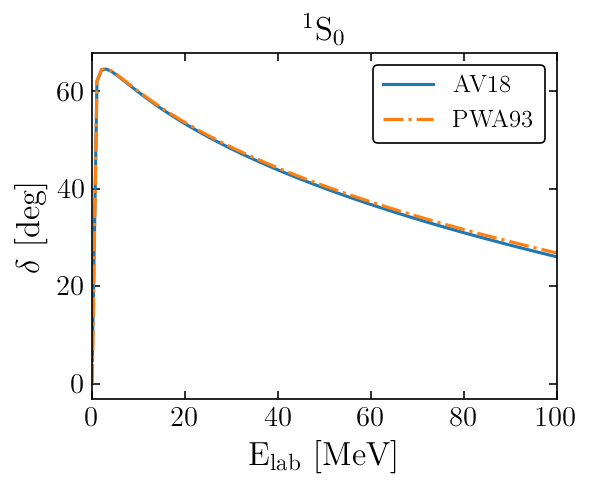

In [23]:
# 1S0 with R-matrix
compare_phase_shifts('1S0')

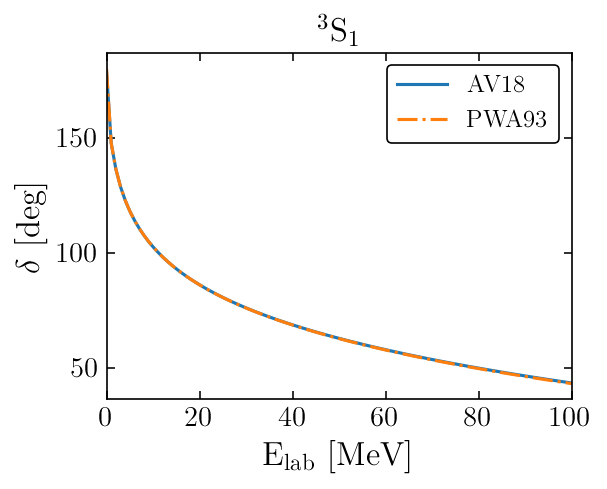

In [24]:
# 3S1 with R-matrix
compare_phase_shifts('3S1')

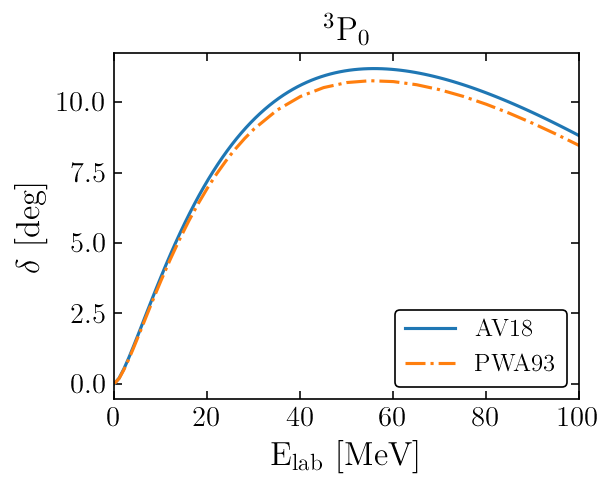

In [25]:
# 3P0 with R-matrix
compare_phase_shifts('3P0')

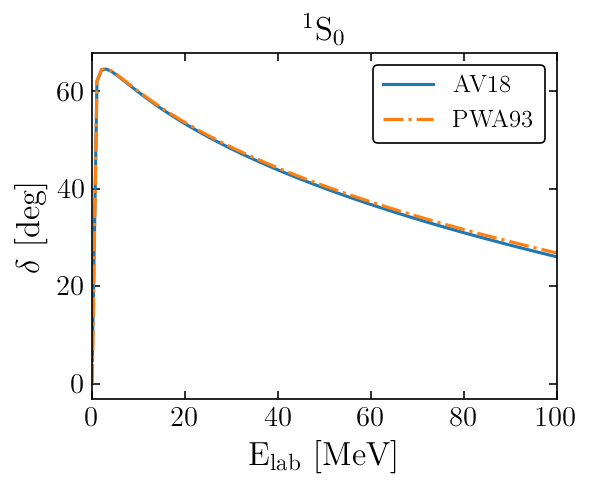

In [26]:
# 1S0 with T-matrix
compare_phase_shifts('1S0', r_matrix=False)

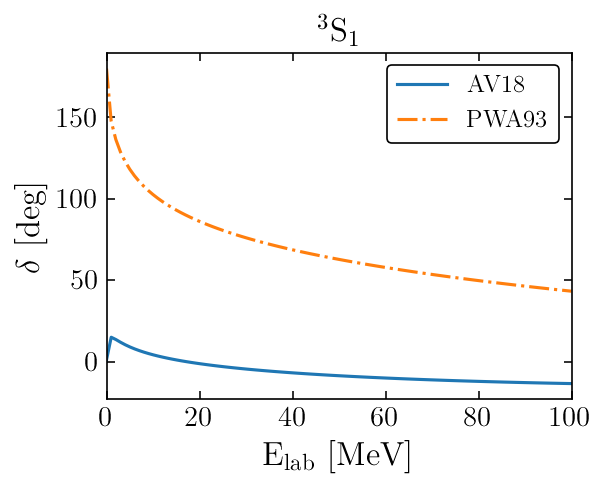

In [27]:
# 3S1 with T-matrix
compare_phase_shifts('3S1', r_matrix=False)

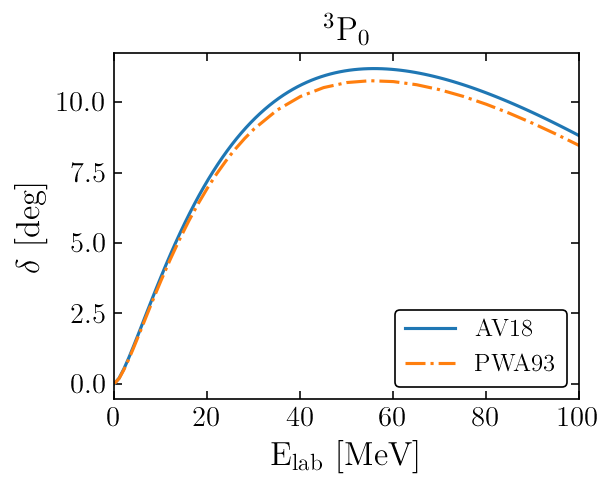

In [28]:
# 3P0 with T-matrix
compare_phase_shifts('3P0', r_matrix=False)

### Test $Q^2$

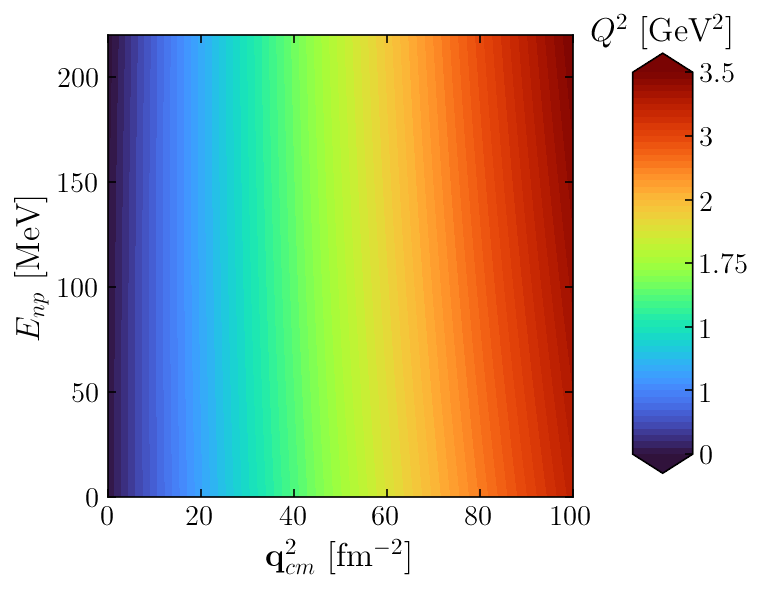

In [29]:
Ep_array = np.linspace(0.0, 220.0, 100)
q2_array = np.linspace(0.0, 100.0, 100)

test_Q2(Ep_array, q2_array)

## Testing unevolved impulse approximation

In [30]:
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')

6.805206057495117


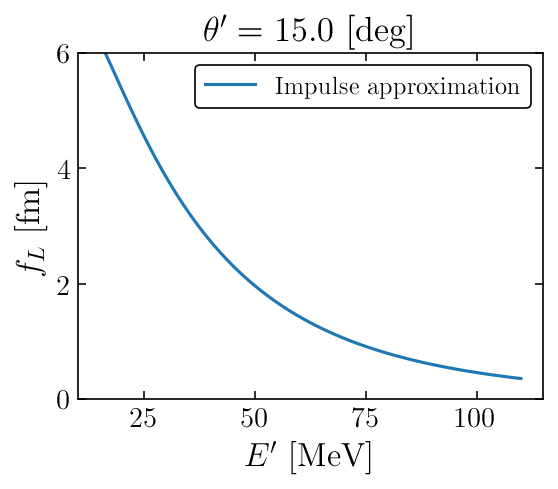

In [31]:
# Quasifree ridge where \omega = 0
Ep_array = np.linspace(10, 110, 100)
thetap = 15.0
plot_fL_wrt_Ep(Ep_array, thetap, channels, x_limits=(10,115), y_limits=(0,6))
# plot_fL_wrt_Ep(Ep_array, thetap, x_limits=(10,115), y_limits=(0,8))

9.699601793093308 0.15294739109682806


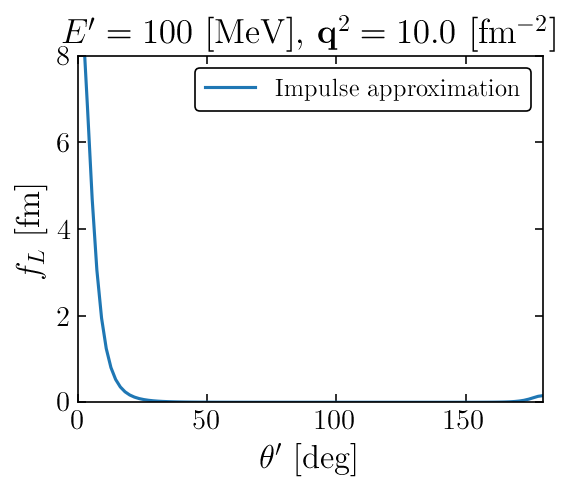

In [32]:
Ep = 100
q = np.sqrt(10)
thetap_array = np.linspace(0.01, 179.9, 100)
plot_fL_wrt_thetap(Ep, thetap_array, q, channels, x_limits=(0,180),
                   y_limits=(0,8))

0.15917413078230402 0.0020128184260121704


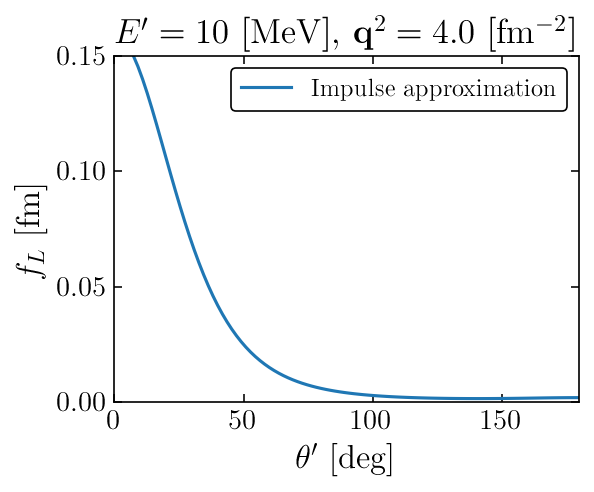

In [33]:
Ep = 10
q = 2
thetap_array = np.linspace(0.01, 179.9, 100)
plot_fL_wrt_thetap(Ep, thetap_array, q, channels, x_limits=(0,180),
                   y_limits=(0,0.15))

In [34]:
# Off by a constant?
print(6.805206057495117 / 5.15)
print(9.699601793093308 / 7.1)
print(0.15917413078230402 / 0.1295348837209302)
# print(np.sqrt(np.pi/2))

# Point at \theta'=180 in E'=100 MeV plot
print(0.15294739109682806 / 0.11838006230529352)

1.3213992344650711
1.3661410976187758
1.2288128588220961
1.2920029616337583


2.499366705376403


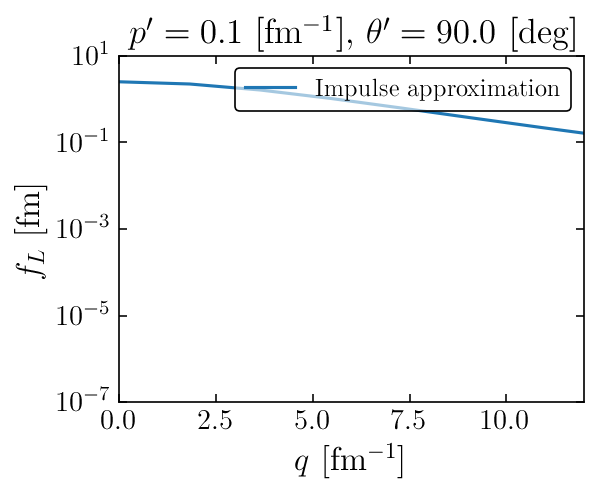

In [35]:
pp = 0.1
thetap = 90.0
q_array = np.linspace(0, 12, 100)

# # x and y limits in More (2017) Fig. 20
# xlim = (0, 12)
# ylim = (1e-7, 1e0)

xlim = (0, 12)
ylim = (1e-7, 1e1)
plot_fL_wrt_q(pp, thetap, q_array, channels, x_limits=xlim, y_limits=ylim)

### Double-check extreme angles $\theta'=0,\pi$ and $p'=q=1$

At $\theta'=0$ expect $\theta_{\pm}=0$

In [36]:
de = DeuteronElectrodisintegration(channels, form_factor_test=True)
Ep_ifm, S_f, m_S_f, m_J_d = 0, 1, 0, 0  # Doesn't matter
pp, thetap, q = 1, 0, 1
overlap = de.overlap_ia(Ep_ifm, pp, thetap, q, S_f, m_S_f, m_J_d, test=True)

\Omega_(p +/- q/2) at theta' = 0.000:
theta_minus = 0.000, theta_plus = 0.000


At $\theta'=\pi$ expect $\theta_{\pm}=\pi$

In [37]:
de = DeuteronElectrodisintegration(channels, form_factor_test=True)
Ep_ifm, S_f, m_S_f, m_J_d = 0, 1, 0, 0  # Doesn't matter
pp, thetap, q = 1, np.pi, 1
overlap = de.overlap_ia(Ep_ifm, pp, thetap, q, S_f, m_S_f, m_J_d, test=True)

\Omega_(p +/- q/2) at theta' = 3.142:
theta_minus = 3.142, theta_plus = 3.142


### Double-check deuteron wave function

In [38]:
de = DeuteronElectrodisintegration(channels)
Ep = 100
q2 = 10
q = np.sqrt(10)
Ep_ifm = Ep / de.hbar_c
pp = de.p_prime(Ep_ifm)
print(f"p' = {pp} fm^-1")
pq = pp + q/2
print(f"p' + q/2 = {pq} fm^-1")

p' = 1.5733807719336366 fm^-1
p' + q/2 = 3.1545196020178263 fm^-1


In [39]:
q_array = np.linspace(0.0,10.0,200)
psi_0_array = de.psi_0_func(q_array)
psi_2_array = de.psi_2_func(q_array)

print(f"Deuteron normalization = {de.norm}")

Deuteron normalization = 0.999999999999999


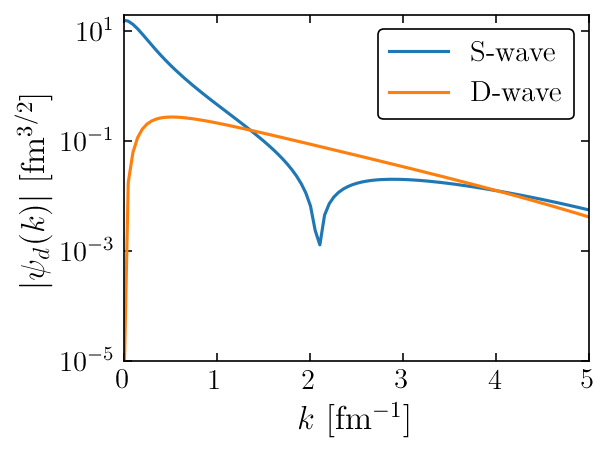

In [40]:
plt.close('all')
f, ax = plt.subplots(figsize=(4, 3))
ax.semilogy(q_array, np.abs(psi_0_array), label='S-wave')
ax.semilogy(q_array, np.abs(psi_2_array), label='D-wave')
ax.set_xlim(0,5)
ax.set_ylim(1e-5,2e1)
ax.legend(loc='upper right')
ax.set_xlabel(r"$k$ [fm$^{-1}$]", fontsize=16)
ax.set_ylabel(r"$|\psi_d(k)|$ [fm$^{3/2}$]", fontsize=16);

### Double-check form factors

In [41]:
Q2_array = np.arange(0.0, 2.0, 0.1)

# My form factors
GEp_at_array = GEp(Q2_array)
GEn_at_array = GEn(Q2_array)

# Sushant's form factors
ff = FormFactors()
GEp_sm_array = ff.GEp(Q2_array)
GEn_sm_array = ff.GEn(Q2_array)

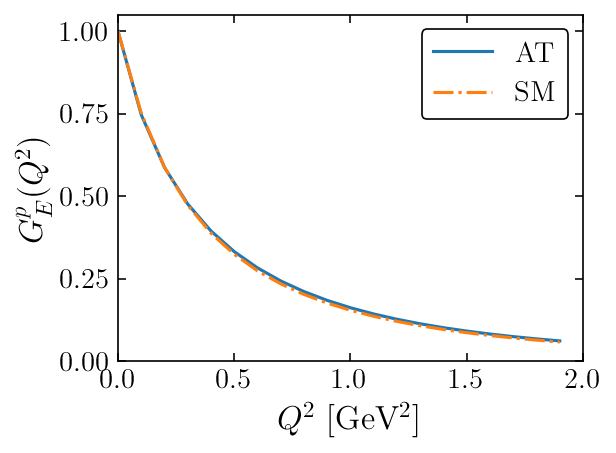

In [42]:
plt.close('all')
f, ax = plt.subplots(figsize=(4, 3))
ax.plot(Q2_array, GEp_at_array, label="AT")
ax.plot(Q2_array, GEp_sm_array, label="SM", ls='dashdot')
ax.set_xlim(0,2)
ax.set_ylim(0.0,1.05)
ax.legend(loc='upper right')
ax.set_xlabel(r"$Q^2$ [GeV$^{2}$]", fontsize=16)
ax.set_ylabel(r"$G_E^p(Q^2)$", fontsize=16);

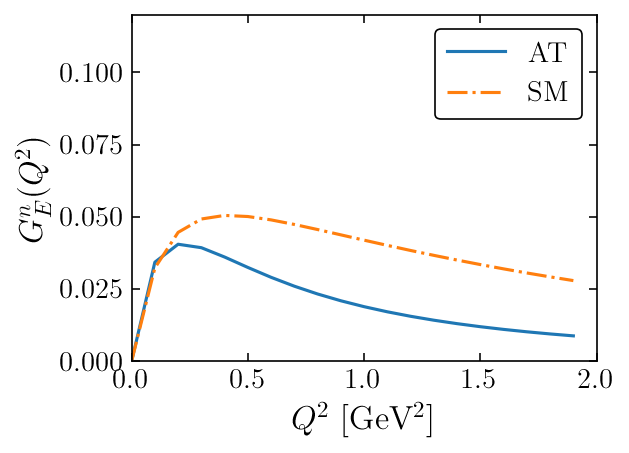

In [43]:
plt.close('all')
f, ax = plt.subplots(figsize=(4, 3))
ax.plot(Q2_array, GEn_at_array, label="AT")
ax.plot(Q2_array, GEn_sm_array, label="SM", ls='dashdot')
ax.set_xlim(0,2)
ax.set_ylim(0.0,0.12)
ax.legend(loc='upper right')
ax.set_xlabel(r"$Q^2$ [GeV$^{2}$]", fontsize=16)
ax.set_ylabel(r"$G_E^n(Q^2)$", fontsize=16);

In [44]:
Q2_ratio_array = np.arange(0.0, 5.0, 0.1)

# My form factors
GEp_at_array = GEp(Q2_ratio_array)

# Sushant's form factors
GEp_sm_array = ff.GEp(Q2_ratio_array)

GD_array = ff.GD(Q2_ratio_array)
ratio_at = GEp_at_array / GD_array
ratio_sm = GEp_sm_array / GD_array

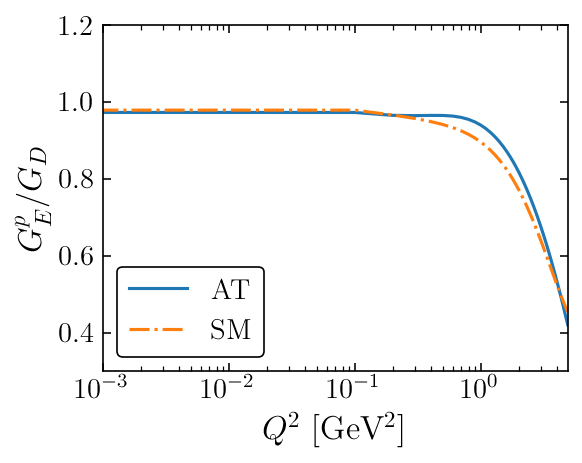

In [45]:
plt.close('all')
f, ax = plt.subplots(figsize=(4, 3))
ax.semilogx(Q2_ratio_array, ratio_at, label="AT")
ax.semilogx(Q2_ratio_array, ratio_sm, label="SM", ls='dashdot')
ax.set_xlim(0.001,4.9)
ax.set_ylim(0.3,1.2)
ax.legend(loc='lower left')
ax.set_xlabel(r"$Q^2$ [GeV$^{2}$]", fontsize=16)
ax.set_ylabel(r"$G_E^p/ G_D$", fontsize=16);